In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords,words

import warnings 
warnings.filterwarnings("ignore")

In [3]:
pd.set_option("display.max_colwidth", 200)
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['axes.titlesize'] = 20

In [4]:
train  = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')

In [5]:
print(train.shape,test.shape)
train.head()

(31962, 3) (17197, 2)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [6]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [7]:
combi = pd.concat([train,test],axis=0).reset_index(drop=True)
combi.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation


In [8]:
# Removing punctuation & Stopwords

stop_words = stopwords.words('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'ve", " ", text)
    text = re.sub(r"i'm", " ", text)
    text = re.sub(r"\'re", " ", text)
    text = re.sub(r"\'d", " ", text)
    text = re.sub(r"\'ll", " ", text)
    text = re.sub('\n',' ',text) 
    text = re.sub('[^a-zA-Z#]', ' ', text)       #Removing punctuations but keeping hashtags
    text = re.sub('\s+', ' ', text)      
    text = ' '.join([i for i in text.split() if i not in stop_words])
    return text

In [9]:
combi['tweet'] = combi.tweet.apply(lambda x: clean_text(x))
combi.head()

,id,label,tweet
0,1,0.0,user father dysfunctional selfish drags kids dysfunction #run
1,2,0.0,user user thanks #lyft credit cannot use cause offer wheelchair vans pdx #disapointed #getthanked
2,3,0.0,bihday majesty
3,4,0.0,#model love u take u time ur
4,5,0.0,factsguide society #motivation


In [10]:
combi.tweet[3]

'#model love u take u time ur'

In [11]:
#TOKENIZATION and removing words less than 3 in length

from nltk.tokenize import word_tokenize
combi['tweet'] = combi.tweet.apply(lambda x: word_tokenize(x.lower())) #word tokenization
combi['tweet'] = combi.tweet.apply(lambda x: [i for i in x if len(i)>3])
combi.head()

,id,label,tweet
0,1,0.0,"[user, father, dysfunctional, selfish, drags, kids, dysfunction]"
1,2,0.0,"[user, user, thanks, lyft, credit, cause, offer, wheelchair, vans, disapointed, getthanked]"
2,3,0.0,"[bihday, majesty]"
3,4,0.0,"[model, love, take, time]"
4,5,0.0,"[factsguide, society, motivation]"


In [12]:
#LEMMATIZATION

from nltk.stem import WordNetLemmatizer

def split_into_lemmas(text):
    lemma = []
    lemmatizer = WordNetLemmatizer()
    for word in text:
        a = lemmatizer.lemmatize(word)
        lemma.append(a)
    return ' '.join(lemma)

combi['tweet'] = combi.tweet.apply(split_into_lemmas)
combi.head()

,id,label,tweet
0,1,0.0,user father dysfunctional selfish drag kid dysfunction
1,2,0.0,user user thanks lyft credit cause offer wheelchair van disapointed getthanked
2,3,0.0,bihday majesty
3,4,0.0,model love take time
4,5,0.0,factsguide society motivation


# Feature Extraction using TFIDF method

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english',ngram_range=(1,2))

# bag-of-words feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi.tweet)
tfidf.shape

(49159, 1000)

In [14]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

# Model Building

Now we will build the model for predicting the sentiment of tweet using different algorithms mentioned below:

1. Logistic Regression
2. Naive Bayes 
3. K Nearest Neighbor
4. Support Vector Machine
5. Decision Tree
6. Random Forest
7. XGBoost
8. LightGBM

# 1. Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [16]:
X = train_tfidf
y = train.label

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1029)

In [18]:
model = LogisticRegression()
model.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
y_pred = model.predict_proba(X_test) 
y_pred = y_pred[:,1] >= 0.3        # if prediction is greater than or equal to 0.3 than 1 else 0
y_pred = y_pred.astype(np.int)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.6


[[2910   33]
 [ 131  123]]


              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2943
           1       0.79      0.48      0.60       254

   micro avg       0.95      0.95      0.95      3197
   macro avg       0.87      0.74      0.79      3197
weighted avg       0.94      0.95      0.94      3197



predicting test dataset tweets and creating submission file

In [20]:
test_pred = model.predict_proba(test_tfidf)
test_pred = test_pred[:,1] >= 0.3
test_pred = test_pred.astype(np.int)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_TFIDF_LR.csv', index=False)

###### Public Leaderboard score: 0.5344262295081966.

# 2. Naive Bayes

In [21]:
from sklearn import naive_bayes

In [22]:
model = naive_bayes.MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
y_pred = model.predict_proba(X_test) 
y_pred = y_pred[:,1] >= 0.3        # if prediction is greater than or equal to 0.3 than 1 else 0
y_pred = y_pred.astype(np.int)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.55470737913486


[[2913   30]
 [ 145  109]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2943
           1       0.78      0.43      0.55       254

   micro avg       0.95      0.95      0.95      3197
   macro avg       0.87      0.71      0.76      3197
weighted avg       0.94      0.95      0.94      3197



predicting test dataset tweets and creating submission file

In [24]:
test_pred = model.predict_proba(test_tfidf)
test_pred = test_pred[:,1] >= 0.3
test_pred = test_pred.astype(np.int)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_TFIDF_NB.csv', index=False)

###### Public Leaderboard score:  0.5306799336650083

# 3. K Nearest Neighbor

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
cv_scores = []
score=0

for i in range(1,10): 
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test,y_pred)
    cv_scores.append(score)

Text(0.5, 1.0, 'K vs F1 score')

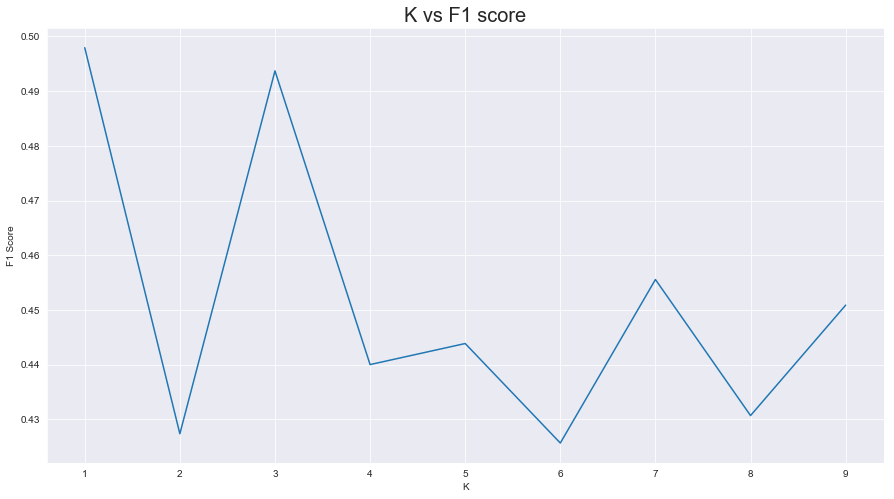

In [32]:
plt.plot(range(1,10),cv_scores)
plt.xlabel('K')
plt.ylabel('F1 Score')
plt.title('K vs F1 score')

From the above plot, it is clearly visible that our model is not performing very well. To choose from the available option f1_score is maximum for K = 3 and hence choosing K = 3 for building the model.

In [33]:
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
 
print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred)) 

0.49370277078085645


[[2898   45]
 [ 156   98]]


              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2943
           1       0.69      0.39      0.49       254

   micro avg       0.94      0.94      0.94      3197
   macro avg       0.82      0.69      0.73      3197
weighted avg       0.93      0.94      0.93      3197



predicting test dataset tweets and creating submission file

In [35]:
test_pred = model.predict(test_tfidf)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_TFIDF_KNN.csv', index=False)

###### Public Leaderboard score :  0.4958123953098827.

# 4. Support Vector Machine

In [36]:
from sklearn import svm

In [37]:
model = svm.SVC(kernel='linear', C=10, probability=True)
model.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [38]:
y_pred = model.predict_proba(X_test) 
y_pred = y_pred[:,1] >= 0.3        # if prediction is greater than or equal to 0.3 than 1 else 0
y_pred = y_pred.astype(np.int)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.5714285714285714


[[2917   26]
 [ 142  112]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2943
           1       0.81      0.44      0.57       254

   micro avg       0.95      0.95      0.95      3197
   macro avg       0.88      0.72      0.77      3197
weighted avg       0.94      0.95      0.94      3197



In [39]:
test_pred = model.predict_proba(test_tfidf)
test_pred = test_pred[:,1] >= 0.3   
test_pred = test_pred.astype(np.int)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_TFIDF_SVM.csv', index=False)

###### Public Leaderboard score : 0.5174825174825175

# 5. Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
model = DecisionTreeClassifier(criterion='entropy',min_samples_split =10,max_features=300)
model.fit(X_train,y_train)  

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=300, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
y_pred = model.predict(X_test)
 
print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.5323383084577115


[[2902   41]
 [ 147  107]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2943
           1       0.72      0.42      0.53       254

   micro avg       0.94      0.94      0.94      3197
   macro avg       0.84      0.70      0.75      3197
weighted avg       0.93      0.94      0.93      3197



In [43]:
test_pred = model.predict(test_tfidf)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_TFIDF_DTree.csv', index=False)

###### Public Leaderboard score :  0.4914089347079038

# 6. Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
model = RandomForestClassifier(n_estimators=40,criterion='entropy',min_samples_split =5,max_features=300)
model.fit(X_train,y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=300, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
y_pred = model.predict(X_test)
 
print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.5298701298701298


[[2914   29]
 [ 152  102]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2943
           1       0.78      0.40      0.53       254

   micro avg       0.94      0.94      0.94      3197
   macro avg       0.86      0.70      0.75      3197
weighted avg       0.94      0.94      0.93      3197



In [47]:
test_pred = model.predict(test_tfidf)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_TFIDF_RF.csv', index=False)

###### Public Leaderboard score :  0.47755834829443444

# 7. XGBoost

In [48]:
import xgboost as xgb

In [49]:
model = xgb.XGBClassifier(n_estimators=200,max_depth=30,min_child_weight=5,subsample=0.8,colsample_bytree=0.7)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bytree=0.7, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=30,
       min_child_weight=5, n_estimators=200, nthread=-1,
       objective='binary:logistic', seed=0, silent=True, subsample=0.8)

In [50]:
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.5177111716621253


[[2925   18]
 [ 159   95]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2943
           1       0.84      0.37      0.52       254

   micro avg       0.94      0.94      0.94      3197
   macro avg       0.89      0.68      0.74      3197
weighted avg       0.94      0.94      0.93      3197



In [51]:
test_pred = model.predict(test_tfidf)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_TFIDF_XGB.csv', index=False)

###### Public Leaderboard score : 0.5152979066022544

| Algorithm | Model F1 Score | Public F1 Score |
| --------- | ---------- | ------------------- |
| Logistic Regression | 0.6 |  0.5344262295081966 |
| Naive Bayes |  0.55470737913486 |  0.5306799336650083 |
| K Nearest Neighbor | 0.49370277078085645 | 0.4958123953098827 |
| SVM | 0.5714285714285714  | 0.5174825174825175 |
| Decision Tree | 0.5323383084577115  | 0.4914089347079038 |
| Random Forest | 0.5298701298701298 | 0.47755834829443444  |
| XGBoost |0.5177111716621253 | 0.5152979066022544 |